# Application of LDA to Twitter data

Following the tutorial outlines previously we can now perform topic modeling on data collected from Twitter.

## Mount the google drive and change to working directory

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd gdrive/MyDrive/Module3/LDA_test

Mounted at /content/gdrive
/content/gdrive/MyDrive/Module3/LDA_test


## Install spacy NLP pipeline

In [ ]:
#Only needs to be done once
#Takes sometime
#Restart runtime after download is complete
!python -m spacy download en_core_web_lg


     |████████████████████████████████| 827.9 MB 1.3 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=01258aab5b97e763d524b2b93620041ac20b0969b4c6cc54fff4e0582e400d1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-jlfklhjd/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


## Import libraries

In [ ]:
import requests
import re
from bs4 import BeautifulSoup
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import gensim
import gensim.corpora as corpora
from gensim import models

import spacy
from wordcloud import WordCloud

from tqdm import tqdm

In [ ]:
# Load default trained pipeline package (https://spacy.io/models/en)
# Used for parsing 
# Parsing = resolve (a sentence) into its component parts and describe their syntactic roles.
nlp = spacy.load('en_core_web_lg')
# In case max_length is set to lower than this (ensure sufficient memory)
nlp.max_length = 1500000 


# Load tweets

In [ ]:
fname = "Location Trend Tweets 2022-04-03.csv"

df_Tweets = pd.read_csv(fname)


In [ ]:
df_Tweets.head()

,screen_name,hashtag,tweet,time_stamp
0,Gringo42106495,Kondele,RT @ekisiangani: I abhor violence anywhere in ...,2022-04-03 16:01:48+00:00
1,mwabilimwagodi,Kondele,RT @kipmurkomen: When DP Ruto team was attacke...,2022-04-03 16:01:43+00:00
2,PeterRatemo4,Kondele,"RT @JKNjenga: For the fourth day running, Kond...",2022-04-03 16:01:41+00:00
3,DavidChirchir,Kondele,RT @NahashonKimemia: President Uhuru Kenyatta ...,2022-04-03 16:01:05+00:00
4,MabawaYaMbu,Kondele,RT @Silvia_Wangeci: Even After ALL The Violenc...,2022-04-03 16:01:01+00:00


## Set up corpus

In [ ]:
# Define function to prepare corpus
def PrepareCorpus(df_tweets, minparalength=1):
    """
    Function to prepare corpus.

    Parameters
    -------------
    df_tweets: pandas dataframe
      Dataframe containing the 'tweet', 'time_stamp', and 'screen_name'
      associated with a tweeted message.
    minparalength: int, default 1
      Minimum length for text to be considered a paragraph

    Returns
    ------------
    twitter:         list of lists
      List of lists to form corpus. There are as many list as paragraphs. 
      Inner list contains lemmatized words from each paragraph.
    twitterwordcloud:    list
      Single list version of the corpus.
    twittertopix:        list of tuples
      Contains minutes ID (date) and weight of each paragraph.

    """

    Tweets = df_tweets['tweet']
    Datetime = df_tweets['time_stamp']
    User = df_tweets['screen_name']


    twitter = []
    twitterwordcloud = []
    twittertopix = []

    for tweetTxt, dt, user in tqdm(zip(Tweets,Datetime,User)):
   
        # Clean text - stage 1
        # Remove white space at the beginning and end
        tweetTxt = tweetTxt.strip()  
        # Replace the \r with null
        tweetTxt = tweetTxt.replace('\r', '') 
        # Replace " " with space.
        tweetTxt = tweetTxt.replace(' ', ' ') 
        # Replace " " with space. 
        tweetTxt = tweetTxt.replace(' ', ' ')
        # Remove extra spaces
        while '  ' in tweetTxt:
            tweetTxt = tweetTxt.replace('  ', ' ') 

        # Clean text - stage 2, using regex (as SpaCy incorrectly parses certain HTML tags)    
        tweetTxt = re.sub(r'(<[^>]*>)|'    # Remove content within HTML tags
                         '([_]+)|'        # Remove series of underscores
                         '(http[^\s]+)|'  # Remove website addresses
                         '((a|p)\.m\.)',  # Remove "a.m" and "p.m."
                         '', tweetTxt)     # Replace with null

        tweetTxt = re.sub('RT?(.*?):', '', tweetTxt,  flags=re.DOTALL)

        # Find length of minutes document for calculating paragraph weights
        # List of paras in minsTxt, where minsTxt is split based on new line characters
        tweetTxtParas = tweetTxt.split('\n') 
        # Set up variable for cumulative word-count in all paras for a given minutes transcript
        cum_paras = 0 
        for para in tweetTxtParas:
          # Only including paragraphs larger than 'minparalength'
          if len(para)>minparalength: 
              cum_paras += len(para)
        
        # Extract paragraphs
        for para in tweetTxtParas:
          # Only extract paragraphs larger than 'minparalength'
          if len(para)>minparalength: 
              
              # Temporary list to store minutes date & para weight tuple
              topixTmp = [] 
              # First element of tuple (minutes date)
              topixTmp.append(user +'_' + dt ) 
              # Second element of tuple (para weight), NB. Calculating weights based on pre-SpaCy-parsed text
              topixTmp.append(len(para)/cum_paras) 
                          
              # Parse cleaned para with SpaCy
              minsPara = nlp(para)
              
              tweetTmp = [] # Temporary list to store individual tokens
              
              # Further cleaning and selection of text characteristics
              for token in minsPara:
                  # Retain words that are not a stop word nor punctuation, and only if a Noun, Adjective or Verb#
                  if token.is_stop == False and token.is_punct == False and (token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ =="VERB"): #
                      # Convert to lower case and retain the lemmatized version of the word (this is a string object)
                      tweetTmp.append(token.lemma_.lower()) 
                      # Add word to WordCloud list
                      twitterwordcloud.append(token.lemma_.lower()) 
              twitter.append(tweetTmp) # Add para to corpus 'list of lists'
              twittertopix.append(topixTmp) # Add minutes date & para weight tuple to list for storing
            
    return twitter, twitterwordcloud, twittertopix


In [ ]:
# A list of lists to form the corpus
# Inner list contains lemmatized words contained in a tweet
Tweets = [] 
# Single list version of the corpus for WordCloud
TweetWordCloud = [] 
# List of tuples. Contains tweet ID (screen_name+time_stamp) and weight of each paragraph
TweetTopix = [] 


# Prepare corpus
Tweets, TweetWordCloud, TweetTopix = PrepareCorpus(df_Tweets)


2475it [00:34, 71.41it/s]


In [ ]:
print(TweetWordCloud[0:10],'\n', len(TweetWordCloud))

['violence', 'world', 'problem', 'discrimination', 'violence', 'team', 'politician', 'day', 'trend', 'attack'] 
 6781


In [ ]:
print(Tweets[0:10],'\n', len(Tweets))

[['violence', 'world', 'problem', 'discrimination', 'violence'], ['team', 'politician'], ['day', 'trend'], [], ['attack', 'pm', 'chopper', 'th'], ['violence'], ['team', 'politician'], ['team', 'politician'], ['team', 'politician'], []] 
 3645


In [ ]:
print(TweetTopix[0:10],'\n', len(TweetTopix))

[['Gringo42106495_2022-04-03 16:01:48+00:00', 1.0], ['mwabilimwagodi_2022-04-03 16:01:43+00:00', 1.0], ['PeterRatemo4_2022-04-03 16:01:41+00:00', 0.6532258064516129], ['PeterRatemo4_2022-04-03 16:01:41+00:00', 0.3467741935483871], ['DavidChirchir_2022-04-03 16:01:05+00:00', 1.0], ['MabawaYaMbu_2022-04-03 16:01:01+00:00', 1.0], ['LashDeck_2022-04-03 16:00:44+00:00', 1.0], ['fa_cadee_2022-04-03 16:00:40+00:00', 1.0], ['JusticeNgeno5_2022-04-03 16:00:35+00:00', 1.0], ['TrendsAnchor_2022-04-03 16:00:23+00:00', 0.5434782608695652]] 
 3645


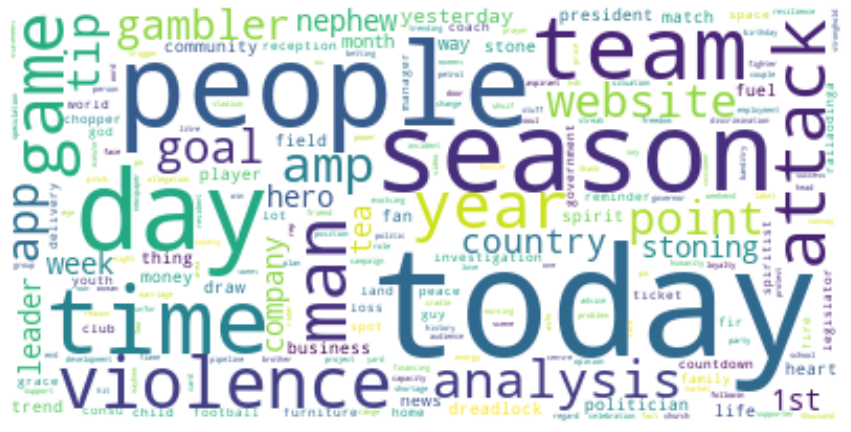

In [ ]:
# Generate and plot WordCloud for full corpus
# Include bigrams by setting collocations to True
# 'join' method used to convert the documents list to text format
wordcloud = WordCloud(background_color="white", collocations=False).generate(','.join(TweetWordCloud)) 

plt.figure(figsize=(15,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

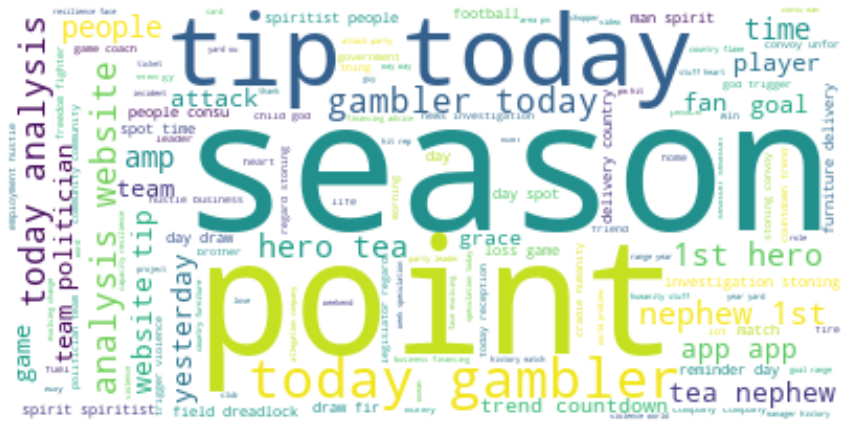

In [ ]:
# Generate and plot WordCloud for full corpus
# Include bigrams by setting collocations to True
# 'join' method used to convert the documents list to text format
wordcloud = WordCloud(background_color="white", collocations=True).generate(','.join(TweetWordCloud)) 

plt.figure(figsize=(15,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Numeric representation of corpus using TF-IDF

In [ ]:
# Form dictionary by mapping word IDs to words
# https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.html
ID2word = corpora.Dictionary(Tweets)

# Set up Bag of Words and TFIDF
# doc2bow converts a collection of words to its bag-of-words representation: a list of (word_id, word_frequency) 2-tuples.
corpus = [ID2word.doc2bow(doc) for doc in Tweets] 
# TFIDF = term frequency–inverse document frequency https://en.wikipedia.org/wiki/Tf%E2%80%93idf
# Fit TF-IDF model
TFIDF = models.TfidfModel(corpus) 
# Apply TF-IDF model
trans_TFIDF = TFIDF[corpus]


In [ ]:
dummy_index = 1
print(trans_TFIDF[dummy_index])
for word in trans_TFIDF[dummy_index]:
  print(ID2word[word[0]])

[(4, 0.7576835062869547), (5, 0.6526221757653554)]
politician
team


## Set up LDA model

In [ ]:
# Set random seed
SEED = 130 
# Set number of topics
NUM_topics = 2
# Set alpha 
ALPHA = 1/NUM_topics
# Set eta 
ETA = 1/NUM_topics
# Number of passes
passes = 10

In [ ]:
# Train LDA model using the corpus
lda_model = gensim.models.LdaMulticore(corpus=trans_TFIDF, 
                                       num_topics=NUM_topics, 
                                       id2word=ID2word, 
                                       random_state=SEED, 
                                       alpha=ALPHA, 
                                       eta=ETA, 
                                       passes=passes)

# Print topics generated from the training corpus
pprint(lda_model.print_topics(num_words=5))


[(0,
  '0.014*"app" + 0.012*"people" + 0.011*"point" + 0.011*"stoning" + '
  '0.011*"team"'),
 (1, '0.020*"today" + 0.017*"day" + 0.016*"season" + 0.013*"time" + 0.010*"m"')]


## Calculate coherence score

Coherence explained [here](https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c)

In [ ]:
# Set up coherence model
# Calculate topic coherence for topic models. Implementation of the four stage topic coherence pipeline:
# segmentation, probability estimation, indirect confirmation measure, aggregation
# Documentation https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/coherencemodel.py
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=Tweets, dictionary=ID2word, coherence='c_v')



# Calculate and print coherence
coherence_lda = coherence_model_lda.get_coherence()
print('-'*50)
print('Coherence Score:', coherence_lda)
print('-'*50)


--------------------------------------------------
Coherence Score: 0.7634214115883127
--------------------------------------------------


## Generate weighted topic proportions for corpus

In [ ]:
TweetTopix_new = []
for x in TweetTopix:
 TweetTopix_new.append(x)

# Set document counter
para_no = 0 
for para in TweetTopix:
    TFIDF_para = TFIDF[corpus[para_no]] # Apply TFIDF model to individual paragraphs in minutes documents
    # Generate and store weighted topic proportions for each para
    # List of tuples ("topic number", "topic proportion") for each para, where 'topic_weight' is the (iterating) tuple
    for topic_weight in lda_model.get_document_topics(TFIDF_para): 
        # Weights are the second element of the pre-appended list, topic proportions are the second element of each tuple
        TweetTopix_new[para_no].append(TweetTopix[para_no][1]*topic_weight[1]) 
    para_no += 1


## Generate aggegate topic mix

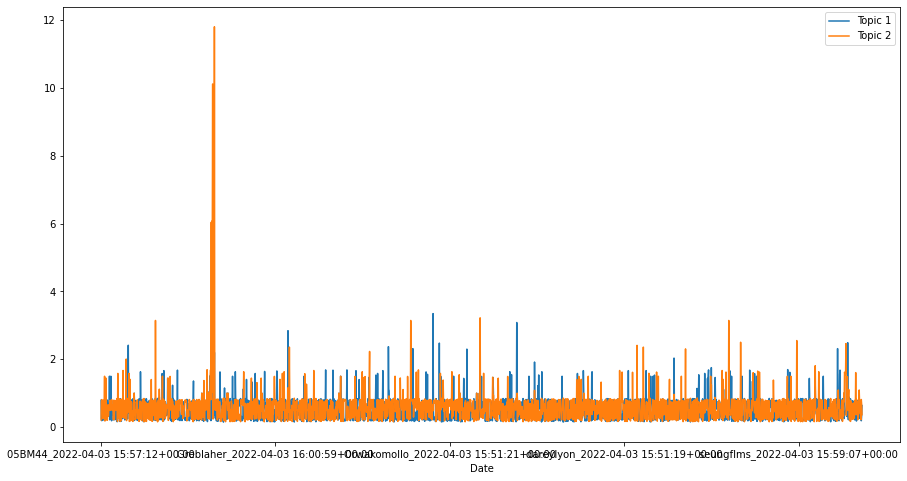

In [ ]:
# List of topics
Topic_list = []
for i in range(NUM_topics):
  Topic_list.append('Topic '+str(i+1))
Columns = ['Date', 'Weight'] + Topic_list

# Form dataframe of weighted topic proportions (paragraphs) - include any chosen topic names
FOMCTopixDF = pd.DataFrame(TweetTopix_new, columns=Columns)

# Aggregate topic mix by minutes documents (weighted sum of paragraphs)
TopixAggDF = pd.pivot_table(FOMCTopixDF, values=Topic_list, index='Date', aggfunc=np.sum)

# Plot results - select which topics to print
TopixAggDF.plot(y=Topic_list, kind='line', use_index=True,figsize=(15,8))


## Print topic word clouds

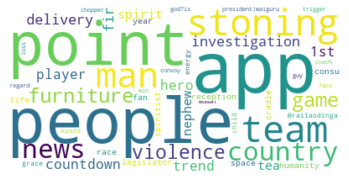

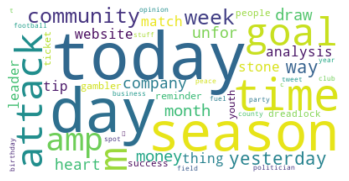

In [ ]:

topic = 0 # Initialize counter
while topic < NUM_topics:
    # Get topics and frequencies and store in a dictionary structure
    # 'dict()' constructor builds dictionaries from sequences (lists) of key-value pairs 
    # This is needed as input for the 'generate_from_frequencies' word cloud function
    topic_words_freq = dict(lda_model.show_topic(topic, topn=50)) 
    topic += 1
    
    # Generate Word Cloud for topic using frequencies
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(topic_words_freq) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    print('\n')

## Test coherence by varying key parameters

In [ ]:
def compute_coherence( alpha, eta, num_topics):

    model = gensim.models.LdaMulticore(corpus=trans_TFIDF, 
                                      num_topics=num_topics, 
                                      id2word=ID2word, 
                                      random_state=SEED, 
                                      alpha=alpha, 
                                      eta=eta, 
                                      passes=passes)
      
    coherencemodel = gensim.models.CoherenceModel(model=model, texts=Tweets, dictionary=ID2word, coherence='c_v')
    coherence_value = coherencemodel.get_coherence()

    return coherence_value
  


## Coherence values for varying number of topics

In [ ]:
def compute_coherence_values_TOPICS(corpus, dictionary, alpha, seed, eta, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.LdaMulticore(corpus=corpus, 
                                           id2word=dictionary, 
                                           alpha=alpha, 
                                           num_topics=num_topics, 
                                           random_state=seed, 
                                           eta=eta, 
                                           passes=passes)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values




In [ ]:
limit=105
start=5
step=10

model_list, coherence_values = compute_coherence_values_TOPICS(corpus=trans_TFIDF, 
                                                               dictionary=ID2word, 
                                                               alpha=ALPHA, 
                                                               seed=SEED, 
                                                               eta=ETA, 
                                                               texts=FOMCMinutes, 
                                                               start=start, 
                                                               limit=limit, 
                                                               step=step)


100%|██████████| 10/10 [03:29<00:00, 20.99s/it]


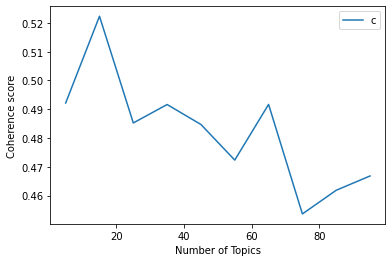

In [ ]:
# Plot graph of coherence values by varying number of topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

## Coherence values for varying eta

In [ ]:

def compute_coherence_values_ETA(corpus, dictionary, num_topics, seed, alpha, texts, start, limit, num_step):
    coherence_values = []
    model_list = []
    for eta in tqdm(np.linspace(start, limit, num_step)):
        model = gensim.models.LdaMulticore(corpus=corpus, 
                                           id2word=dictionary, 
                                           num_topics=num_topics, 
                                           random_state=seed, 
                                           alpha=alpha, 
                                           eta=eta, 
                                           passes=passes)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values



In [ ]:
limit=1.5/NUM_topics
start=0.5/NUM_topics
num_step=10

model_list, coherence_values = compute_coherence_values_ETA(corpus=trans_TFIDF, 
                                                            dictionary=ID2word, 
                                                            num_topics=NUM_topics, 
                                                            seed=SEED, 
                                                            alpha=ALPHA, 
                                                            texts=FOMCMinutes, 
                                                            start=start, 
                                                            limit=limit, 
                                                            num_step=num_step)


100%|██████████| 10/10 [02:10<00:00, 13.07s/it]


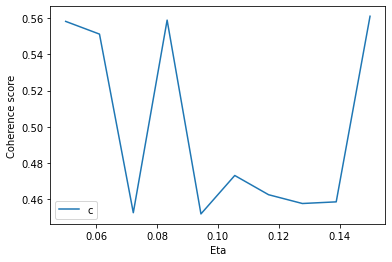

In [ ]:
# Plot graph of coherence values by varying eta
#x = range(start, limit, step)
x = np.linspace(start, limit, num_step)
plt.plot(x, coherence_values)
plt.xlabel("Eta")
plt.ylabel("Coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

## Coherence values for varying alpha

In [ ]:

def compute_coherence_values_ALPHA(corpus, dictionary, num_topics, seed, eta, texts, start, limit, num_step):
    coherence_values = []
    model_list = []
    for alpha in tqdm(np.linspace(start, limit, num_step)):
        model = gensim.models.LdaMulticore(corpus=corpus, 
                                           id2word=dictionary, 
                                           num_topics=num_topics, 
                                           random_state=seed, 
                                           eta=eta, 
                                           alpha=alpha, 
                                           passes=passes)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


In [ ]:
limit=1.5/NUM_topics
start=0.5/NUM_topics
num_step = 10

model_list, coherence_values = compute_coherence_values_ALPHA(dictionary=ID2word, 
                                                              corpus=trans_TFIDF, 
                                                              num_topics=NUM_topics, 
                                                              seed=SEED, 
                                                              eta=ETA, 
                                                              texts=FOMCMinutes, 
                                                              start=start, 
                                                              limit=limit, 
                                                              num_step=num_step)


100%|██████████| 10/10 [02:38<00:00, 15.88s/it]


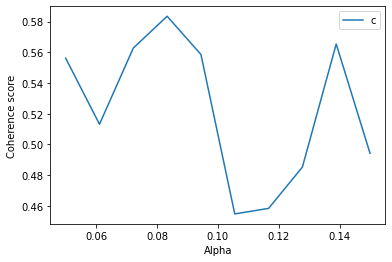

In [ ]:

# Plot graph of coherence values by varying alpha
x = np.linspace(start, limit, num_step)
plt.plot(x , coherence_values)
plt.xlabel("Alpha")
plt.ylabel("Coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

## Coherence values for varying seed

In [ ]:

def compute_coherence_values_SEED(corpus, dictionary, alpha, num_topics, eta, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for seed in tqdm(range(start, limit, step)):
        model = gensim.models.LdaMulticore(corpus=corpus, 
                                           id2word=dictionary, 
                                           alpha=alpha, 
                                           num_topics=num_topics, 
                                           eta=eta, 
                                           random_state=seed, 
                                           passes=passes)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values



In [ ]:
limit=10
start=1
step=1

model_list, coherence_values = compute_coherence_values_SEED(corpus=trans_TFIDF, 
                                                             dictionary=ID2word, 
                                                             alpha=ALPHA, 
                                                             num_topics=NUM_topics, 
                                                             eta=ETA, 
                                                             texts=FOMCMinutes, 
                                                             start=start, 
                                                             limit=limit, 
                                                             step=step)



100%|██████████| 9/9 [02:17<00:00, 15.27s/it]


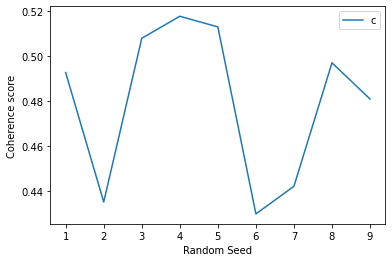

In [ ]:
# Plot graph of coherence values by varying seed
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Random Seed")
plt.ylabel("Coherence score")
plt.legend(("coherence"), loc='best')
plt.show()